Example of Variable Anisotropic Dispersion
==


In [1]:
import os
import stompy.model.delft.waq_scenario as dwaq
import numpy as np

# common code across the dispersion tracer testing
import tracer_common as tc 

import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
# Load the most recent aggregated, non-tidal hydrodynamics
hydro=dwaq.HydroFiles("../../agg141_tau-lp/com-agg141_tau-lp.hyd")
# The precomputed dispersion coefficients are in a text file in the
# same directory
dsp_txt_fn=os.path.join(os.path.dirname(hydro.hyd_path),'dispersions.txt')

In [3]:
# For reference, this code generates the coefficients
if not os.path.exists(dsp_txt_fn):
    print("Generating variable dispersion coefficients")

    # The coefficients come from differencing the tidal and nontidal
    # runs, so load a tidal run that is otherwise identical
    hydro_tidal=dwaq.HydroFiles("../../agg141_tau/com-agg141_tau.hyd")

    # K_scale=0.12 emerged as the best choice across several tracer test.
    # N.B. not using the Decaying plume aspect of this class. It just happens
    # to have the dispersion coefficient code mixed in.
    run=tc.DecayingPlumeKauto(hydro=hydro,hydro_tidal=hydro_tidal,K_scale=0.12)
    # this handles the calculation of the coefficients
    K=run.disp_array() 
    # The result is a 1D array with 6179 elements.  That corresponds to 4910
    # horizontal exchanges (491 per layer, 10 layers), and 1269 vertical
    # exchanges, which are given 0 dispersion here. Note that this is in 
    # addition to vertical dispersion brought in as part of the hydro and
    # in addition to base_x_dispersion and base_z_dispersion.
    
    # Save the result as a text file
    np.savetxt(dsp_txt_fn,K)

<IPython.core.display.Javascript object>


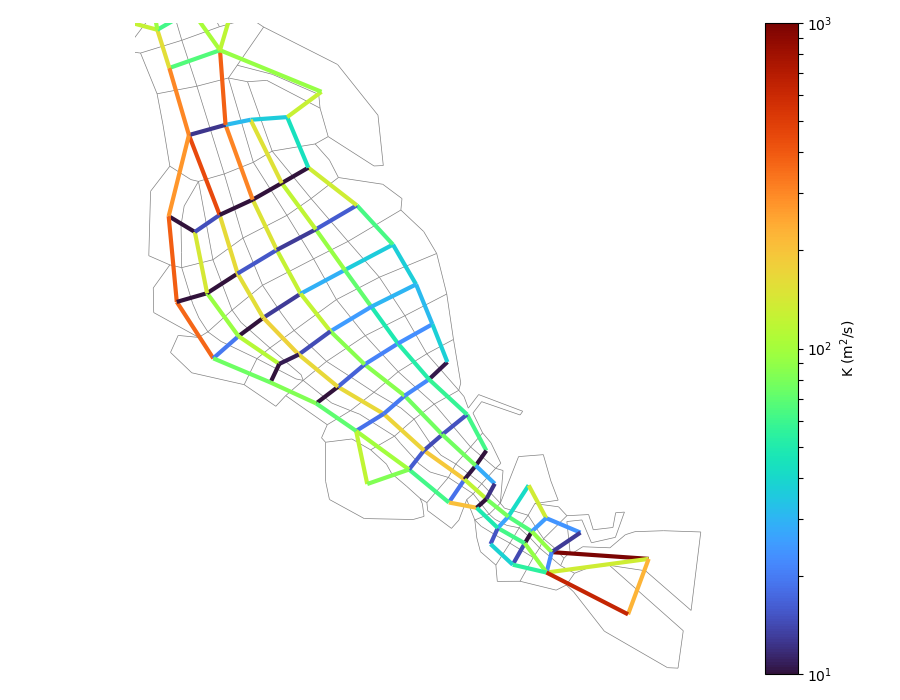

In [48]:
# Visualize the dispersion coefficients on the grid
K=np.loadtxt(dsp_txt_fn)
g=hydro.grid()
hydro.infer_2d_links()
Klink=K[:hydro.n_2d_links]

from matplotlib import collections, colors
from stompy.plot.cmap import load_gradient
turbo=load_gradient('turbo.cpt')

sel=hydro.links[:,0]>0
segs=[]
ctrs=g.cells_centroid()

segs=ctrs[ hydro.links[sel,:] ]
Kcoll=collections.LineCollection(segs,array=Klink[sel],
                                 norm=colors.LogNorm(vmin=10,vmax=1000),
                                 cmap=turbo,lw=3.0)

fig,ax=plt.subplots(1,1,figsize=(9,7))
g.plot_edges(color='0.5',lw=0.5)
ax.axis('off')
ax.add_collection(Kcoll)
plt.colorbar(Kcoll,label="K (m$^2$/s)")
fig.tight_layout()
ax.axis(tc.Blobber.zoom) ;

Original Run 
---

A short initial condition plume run with the original aggregated, nontidal
hydrodynamics and no additional dispersion.

INFO:WaqModel: start time updated from hydro: 2012-08-01T00:00:00.000000
INFO:WaqModel: stop time update from hydro: 2013-10-01T00:00:00.000000
INFO:HydroFiles:Bottom depths will be inferred
INFO:HydroFiles:Segment depth will be inferred
INFO:WaqModel:Parameters gleaned from hydro: NamedObjects([('surf', <stompy.model.delft.waq_scenario.ParameterSpatial object at 0x7fc5201c7c50>), ('vertdisper', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7fc5201cb4e0>), ('tau', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7fc5200c1fd0>), ('salinity', <stompy.model.delft.waq_scenario.ParameterSpatioTemporal object at 0x7fc5201cb0f0>)])
INFO:WaqModel:Writing hydro data
INFO:HydroFiles:Using .bnd file, not writing out kludgey boundary-links.csv
INFO:HydroFiles:Writing hyd file
INFO:HydroFiles:Bottom depths will be inferred
INFO:HydroFiles:Segment depth will be inferred
INFO:HydroFiles:Bottom depths will be inferred
INFO:HydroFiles:Segment depth will be inf

<IPython.core.display.Javascript object>


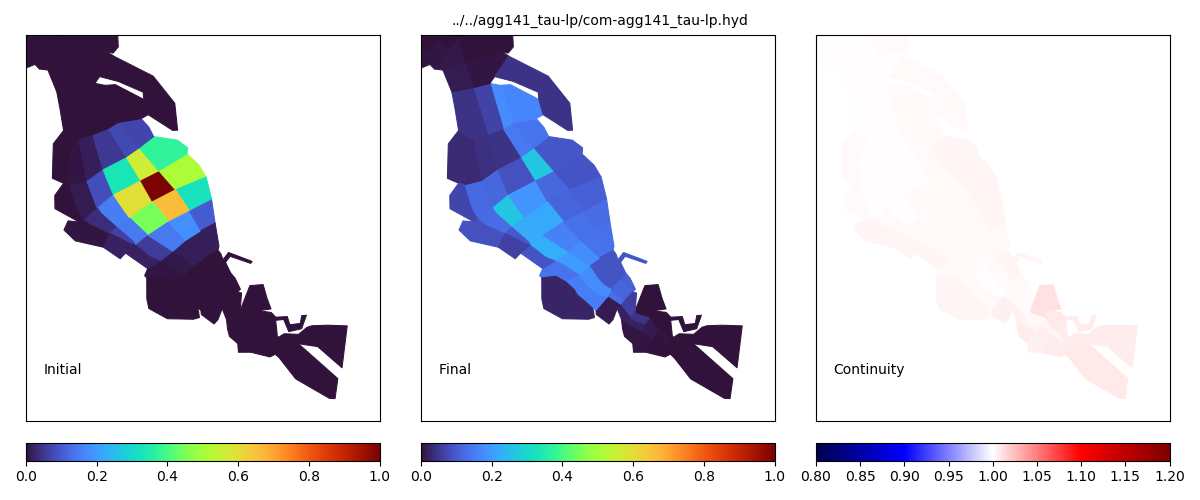

In [39]:
# Original setup
run=tc.Blobber(hydro=hydro,base_path="test_noK")
run.run_waq_model()
run.figure_summary()

Variable Anisotropic Dispersion
---

The interface here is a bit cumbersome, but if the results are promising
we can discuss how to streamline this. 

In the results, note that there is significant longitudinal dispersion.

INFO:root:Run seems to exist -- will not run again


<IPython.core.display.Javascript object>


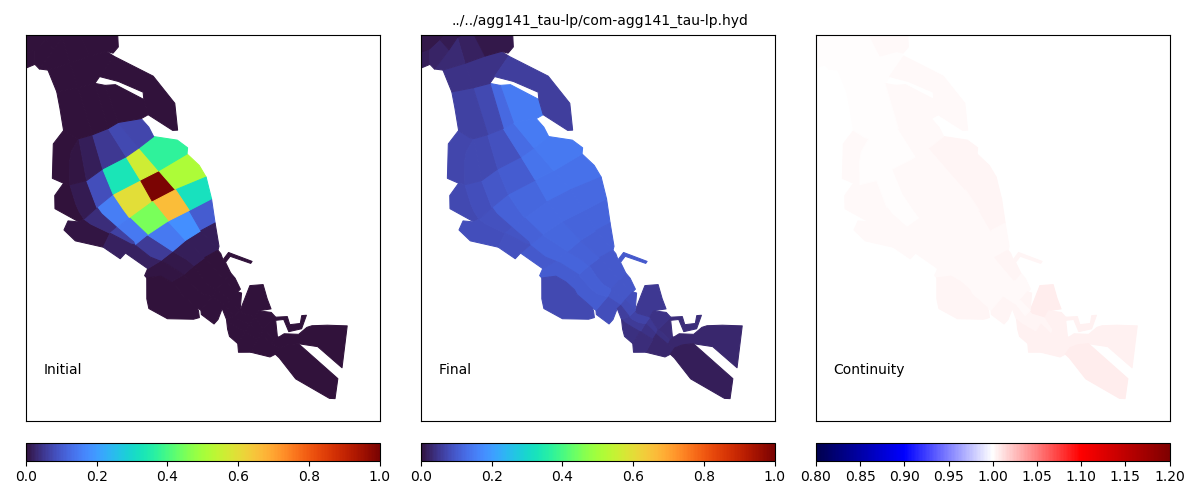

In [52]:
# With dispersion 
K=np.loadtxt(dsp_txt_fn)

class BlobberWithK(tc.Blobber):
    def setup_model(self):
        super(BlobberWithK,self).setup_model()
        # the name doesn't matter.
        # substances=".*" means apply this to all substances.
        # In the input file, look for "dispersion arrays" and
        # "INCLUDE 'dispersions.dsp'"
        # to see how this is passed to dwaq.
        self.wm.dispersions['anisoK']=dwaq.DispArray(substances=".*",data=K)
run=BlobberWithK(hydro=hydro,base_path="test_K")
run.run_waq_model()
run.figure_summary()

Constant Dispersion
---

For comparison, this run uses a constant horizontal dispersion coefficient
of 75 m$^2$/s. Note how much more lateral dispersion there is compared to the
above.

INFO:root:Run seems to exist -- will not run again


<IPython.core.display.Javascript object>


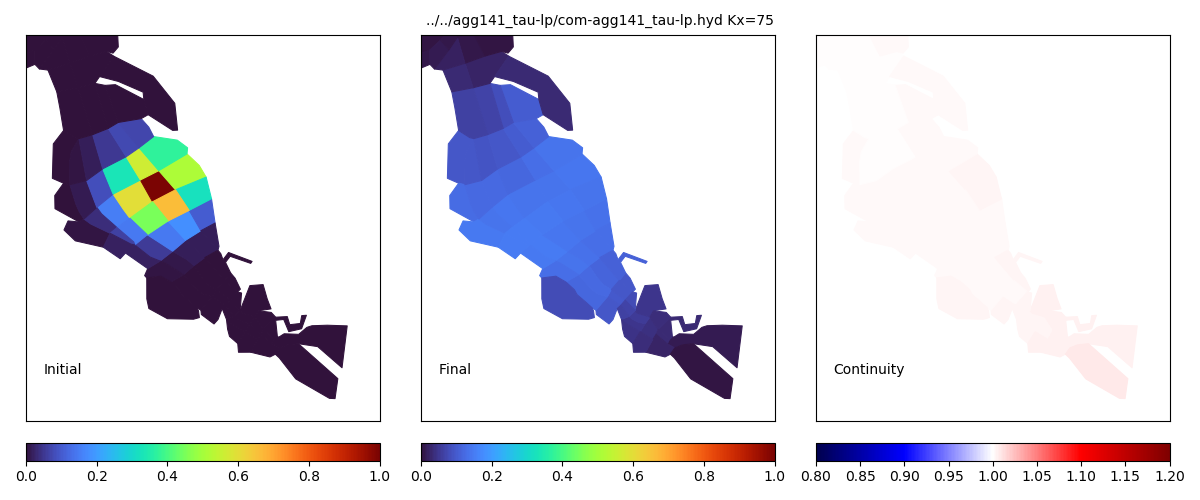

In [53]:
# With dispersion 
run=tc.Blobber(hydro=hydro,base_path="test_constant_K",base_x_dispersion=75)
run.run_waq_model()
run.figure_summary()